In [1]:
# GUROBIでセットしてsigmaまで算出する
# LP_approach_2ではvalue functionに勝っている
# もしこれでも勝つなら、pulp(method = GUROBI)での結果は単にPulpの性能が悪いということに帰着

% matplotlib inline
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
from gurobipy import *
import time

class SimpleOG(object):

    def __init__(self, B=10, M=5, alpha=0.5, beta=0.9):

        self.B, self.M, self.alpha, self.beta  = B, M, alpha, beta
        self.n = B + M + 1
        self.m = M + 1

        self.R = np.empty((self.n, self.m))
        self.Q = np.zeros((self.n, self.m, self.n))

        self.populate_Q()
        self.populate_R()

    def u(self, c):
        return c**self.alpha

    def populate_R(self):

        for s in range(self.n):
            for a in range(self.m):
                self.R[s, a] = self.u(s - a) if a <= s else -np.inf

    def populate_Q(self):

        for a in range(self.m):
            self.Q[:, a, a:(a + self.B + 1)] = 1.0 / (self.B + 1)

# Exact LP (GURPBI setting)
def LP_approach(setting):
    num_state = range(1, setting.num_states + 1)
    num_action = range(1, setting.num_actions + 1)
    LP = Model()
    
    # solve
    x = {}
    for i in num_state:
        x[i ] = LP.addVar(vtype = "C", name = "x(%s)" %(i))
    LP.update()
    
    for i in num_state:
        for j in num_action:
            LP.addConstr((x[i] - setting.beta * quicksum(setting.Q[i-1, j-1, k-1] * x[k] for k in num_state)) >= setting.R[i-1,j-1])
            
    LP.setObjective(quicksum(x[i] for i in num_state))
    LP.params.OutputFlag = 0
    LP.optimize()
    
    # v
    v = np.empty(setting.num_states)
    count = 0
    for value in LP.getVars():
        v[count] = value.X
        count += 1
        
    # sigma
    sigma = setting.compute_greedy(v)
    
    #result
    res = qe.markov.ddp.DPSolveResult(v=v, sigma = sigma,
                            mc=setting.controlled_mc(sigma),
                            method = 'Exact Linear Programming (GUROBI setting)',
                            )
    
    
    return res

    
# linear programming time
def elapse_LP(setting):
    start = time.time()
    LP_approach(setting)
    return time.time() - start

# value function time
def elapse_value(setting):
    start = time.time()
    setting.solve(method='value_iteration')
    elapsed_time = time.time() - start
    return elapsed_time

# plot time until num_state = n
def plot_graph(n, shock, discount):
    a = [None] * n
    b = [None] * n
    for i in range(n):
        h = SimpleOG(M = i, B = shock, beta = discount)
        d = qe.markov.DiscreteDP(h.R, h.Q, h.beta)
        a[i] = elapse_LP(d)
        b[i] = elapse_value(d)

    plt.plot(a)
    plt.plot(b)
    
# time changing beta LP
def plot_beta_LP(shock, state, betas):
    n = [None] * len(betas)
    for i, value in enumerate(betas):
        model = SimpleOG(B = shock, M = state, beta = value)
        ddp = qe.markov.DiscreteDP(model.R, model.Q, model.beta)
        n[i] = elapse_LP(ddp)
    plt.plot(n)
    
#time changing beta value function
def plot_beta_value(shock, state, betas):
    n = [None] * len(betas)
    for i, value in enumerate(betas):
        model = SimpleOG(B = shock, M = state, beta = value)
        ddp = qe.markov.DiscreteDP(model.R, model.Q, model.beta)
        n[i] = elapse_value(ddp)
    plt.plot(n)

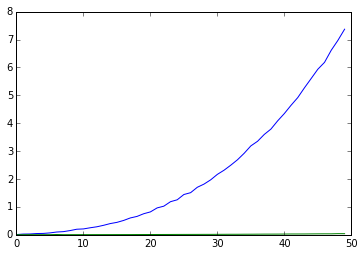

In [5]:
plot_graph(50, 10, 0.99)

In [6]:
# value function の精度を変えてみる
def plot_eps(setting, eps):
    for i in eps:
        start = time.time()
        setting.solve(method='value_iteration', epsilon = i)
        elapsed_time = time.time() - start
        print "epsilon =" ,i
        print elapsed_time

In [11]:
# 正直そんなに変わらない
model = SimpleOG(B = 10, M = 200, beta = 0.99)
ddp = qe.markov.DiscreteDP(model.R, model.Q, model.beta)
eps = [0.005, 0.001, 0.0001, 0.00001, 1e-10]

plot_eps(ddp, eps)

epsilon = 0.005
2.42012906075
epsilon = 0.001
2.31957101822
epsilon = 0.0001
2.3298728466
epsilon = 1e-05
2.32936692238
epsilon = 1e-10
2.32401609421


In [12]:
# 一応LPでの計算時間
#とてもおそいですね
# 精度のせいではなさそう
# discrete 速度検証で続きをやります
elapse_LP(ddp)

417.5036208629608